In [2]:
import os, json, collections

import sqlite3
from sqlite3 import Error
import pandas as pd
import numpy as np
from tabulate import tabulate
import matplotlib.pyplot as plt

# Meta Data Management

using sqlite3 to manage data

columns
['id', 'noise_ratio', 'v', 'alpha', 'dataset', 'model', 'num_epoch']


In [3]:
def connect(db_file="./meta-noise-ratio.db"):
    try:
        conn = sqlite3.connect(db_file)
        return conn
    except Error as e:
        print(e)
    return None

In [4]:
def create_table():
    with connect() as conn:
        c = conn.cursor()
        c.execute(
            """
            CREATE TABLE IF NOT EXISTS tasks (
            id text PRIMARY KEY,
            noise_ratio float NOT NULL,
            v float NOT NULL,
            alpha float NOT NULL,
            weight_decay float NOT NULL,
            dataset text NOT NULL,
            model text NOT NULL,
            num_epoch integer NOT NULL,
            path text NOT NULL
            );
            """
        )
        conn.commit()


In [5]:
def scan(log_dir='log'):
    with connect() as conn:
        c = conn.cursor()
        for dataset in os.listdir(log_dir):
            count = 0
            if dataset == ".DS_Store":
                continue
            dataset_dir = os.path.join(log_dir, dataset)
            for file in os.listdir(dataset_dir):
                tmp_record = {}
                if file.split('.')[-1] == 'meta':
                    fprefix = file[:-5]
                    if not os.path.exists(os.path.join(dataset_dir, fprefix + '.log')):
                        continue
                    with open(os.path.join(dataset_dir, 
                                           fprefix + '.meta'), 'rt') as f:
                        metainfo = json.load(f)
                    with open(os.path.join(dataset_dir,
                                           fprefix + '.log'), 'rt') as f:
                        df = pd.read_csv(f)
                    if len(df) < 50:
                        print("sequence too short", fprefix, len(df))
                        continue
                    info = (dataset_dir+fprefix,
                            metainfo['noise_ratio'],
                            metainfo['v'],
                            metainfo['alpha'],
                            metainfo.get('weight_decay', 0),
                            metainfo['dataset'],
                            metainfo['model'],
                            len(df),
                            "{}/{}.log".format(dataset_dir, fprefix))
                    try:
                        c.execute(
                            """
                            INSERT INTO 
                            tasks(id, noise_ratio, v, alpha, weight_decay, dataset, model, num_epoch, path) 
                            VALUES(?, ?, ?, ?, ?, ?, ?, ?, ?)
                            """, info
                        )
                        count += 1
                    except Error as e:
                        pass
            print("new", dataset, count)
        conn.commit()

In [6]:
scan()

new MNIST 0
sequence too short add_=0_5-200205-0213385ac3-LSTMATT 0
sequence too short add_=0_5-200205-0213171a3b-LSTMATT 0
sequence too short add_==0.25-200205-0214340526-LSTMATT 0
sequence too short add_=0_5-200205-0213384679-LSTMATT 0
sequence too short add_=0_5-200205-0214297386-LSTMATT 0
sequence too short add_==0.25-200205-0214344713-LSTMATT 0
sequence too short add_=0_5-200205-0212486349-LSTMATT 0
sequence too short add_==0.25-200205-021436bd27-LSTMATT 0
sequence too short add_=0_5-200205-0214297949-LSTMATT 0
sequence too short add_==0.25-200205-02143764fd-LSTMATT 0
sequence too short add_=0_5-200205-02131794bb-LSTMATT 0
sequence too short add_=0_5-200205-17212429da-LSTMATT 9
sequence too short add_==0.25-200205-02143689ca-LSTMATT 0
sequence too short add_==0.25-200205-021437874c-LSTMATT 0
sequence too short add_=0_5-200205-021248f4d0-LSTMATT 0
sequence too short add_==0.25-200205-021436db84-LSTMATT 0
new IMDB 0
sequence too short add_0.8_alpha_v=0.25-200205-215320df6c-ResNet18 

# Plots

## General Function

In [61]:
def plot_label_noise(selection_dict, iter_var, iter_var_name=None, iter_filter=None, ax=plt):
    sql = "SELECT {}, path FROM tasks WHERE ".format(iter_var)
    sql += " and ".join("{}={}".format(k, '"{}"'.format(v) if isinstance(v, str) else v) 
                        for k, v in selection_dict.items())
    sql += " ORDER BY {} ASC ".format(iter_var)
    print(sql)
    test_acc_dict = collections.defaultdict(list)
    with connect() as conn:
        c = conn.cursor()
        c.execute(sql)
        for iter_value, path in c.fetchall():
            df = pd.read_csv(path)
            df.columns = [c.strip() for c in df.columns]
            test_acc_dict[iter_value].append(np.asarray(df['test_acc']).reshape(1, -1))

    header = ["IterVar", "IterValue", "SubSeqLen", "Best", "AVE"]
    records = []
            
    for iter_value, seq_list in test_acc_dict.items():
        if iter_filter:
            if not iter_filter(iter_value):
                continue
        if len(seq_list) > 1:
            cseq = np.concatenate(seq_list, 0)
            ave = cseq.mean(0)
            err = cseq.std(0)
        else:
            seq = seq_list[0]
            ave = np.asarray([np.mean(seq[0, max(0, i-1): min(len(seq[0]), i+1)]) for i in range(len(seq[0]))])
            err = np.asarray([np.std( seq[0, max(0, i-1): min(len(seq[0]), i+1)]) for i in range(len(seq[0]))])
        x = np.arange(len(ave))
        ax.plot(x, ave, label='{}={}'.format(iter_var_name, iter_value))
        ax.fill_between(x, ave-err, ave+err, alpha=0.2)        
        records.append((iter_var, iter_value, len(seq_list), np.max(ave), np.mean(ave[-10:])))

    print(tabulate(records, headers=header))


## Snippet

SELECT alpha, path FROM tasks WHERE noise_ratio=0.4 and v=0.5 and weight_decay=0 and model="LSTMATT" and dataset="IMDB" ORDER BY alpha ASC 
IterVar      IterValue    SubSeqLen     Best      AVE
---------  -----------  -----------  -------  -------
alpha          -1                 3  62.8351  54.9141
alpha          -0.5               2  61.6287  54.4045
alpha           0                 2  59.0214  53.6204
alpha           0.5               3  61.068   54.4399
alpha           0.99              2  60.6936  54.718
alpha           0.9999            2  55.7402  53.7246
alpha           1                 3  55.5344  54.4974


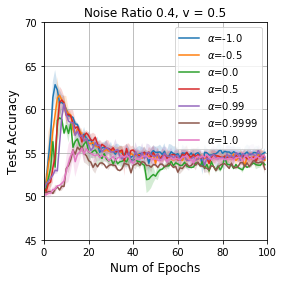

In [62]:
selection_dict = {"noise_ratio": 0.4,
                  "v":0.5,
                  "weight_decay": 0,
                  "model": "LSTMATT",
                  "dataset": "IMDB"}

iter_var='alpha'
iter_var_name=r'$\alpha$'

plt.figure(figsize=(4,4))
plot_label_noise(selection_dict, iter_var, iter_var_name)
plt.legend()
plt.title(r"Noise Ratio 0.4, v = 0.5", fontsize=12)
plt.xlabel("Num of Epochs", fontsize=12)
plt.ylabel("Test Accuracy", fontsize=12)
plt.xlim([0, 100])
plt.ylim([45, 70])
plt.grid()
plt.show()

# IMDB

SELECT alpha, path FROM tasks WHERE noise_ratio=0.4 and v=0.5 and weight_decay=0 and model="LSTMATT" and dataset="IMDB" ORDER BY alpha ASC 
IterVar      IterValue    SubSeqLen     Best      AVE
---------  -----------  -----------  -------  -------
alpha          -1                 3  62.8351  54.9141
alpha          -0.5               2  61.6287  54.4045
alpha           0                 2  59.0214  53.6204
alpha           0.5               3  61.068   54.4399
alpha           0.99              2  60.6936  54.718
alpha           0.9999            2  55.7402  53.7246
alpha           1                 3  55.5344  54.4974


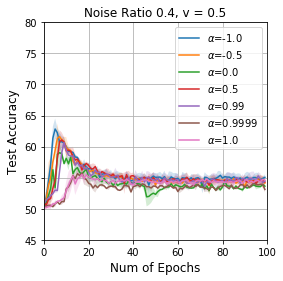

In [83]:
selection_dict = {"noise_ratio": 0.4,
                  "v":0.5,
                  "weight_decay": 0,
                  "model": "LSTMATT",
                  "dataset": "IMDB"}

iter_var='alpha'
iter_var_name=r'$\alpha$'

plt.figure(figsize=(4,4))
plot_label_noise(selection_dict, iter_var, iter_var_name)
plt.legend()
plt.title(r"Noise Ratio 0.4, v = 0.5", fontsize=12)
plt.xlabel("Num of Epochs", fontsize=12)
plt.ylabel("Test Accuracy", fontsize=12)
plt.xlim([0, 100])
plt.ylim([45, 80])
plt.grid()
plt.show()

SELECT v, path FROM tasks WHERE noise_ratio=0.4 and alpha=0.5 and weight_decay=0 and model="LSTMATT" and dataset="IMDB" ORDER BY v ASC 
IterVar      IterValue    SubSeqLen     Best      AVE
---------  -----------  -----------  -------  -------
v                 0.25            3  63.6139  54.5856
v                 0.5             3  61.068   54.4399
v                 1               3  55.6712  54.2015
v                 2               3  57.0607  54.63


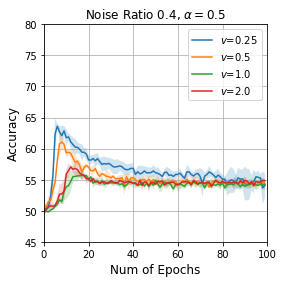

In [82]:
selection_dict = {"noise_ratio": 0.4, 
                  "alpha":0.5,
                  "weight_decay": 0,
                  "model": "LSTMATT",
                  "dataset": "IMDB"}
iter_var='v'
iter_var_name=r'$v$'

plt.figure(figsize=(4,4))
plot_label_noise(selection_dict, iter_var, iter_var_name, iter_filter=lambda x: x<4)
plt.legend()
plt.title(r"Noise Ratio 0.4, $\alpha=0.5$", fontsize=12)
plt.xlabel("Num of Epochs", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.xlim([0, 100])
plt.ylim([45, 80])
plt.grid()
plt.show()

SELECT alpha, path FROM tasks WHERE noise_ratio=0.2 and v=0.5 and weight_decay=0 and model="LSTMATT" and dataset="IMDB" ORDER BY alpha ASC 
IterVar      IterValue    SubSeqLen     Best      AVE
---------  -----------  -----------  -------  -------
alpha          -1                 1  69.5392  59.9776
alpha          -0.5               1  72.4857  65.1718
alpha           0                 1  73.1916  66.2325
alpha           0.5               2  73.5627  65.1328
alpha           0.99              1  72.2903  64.7294
alpha           0.9999            1  70.515   65.3195
alpha           1                 2  71.0212  65.3748


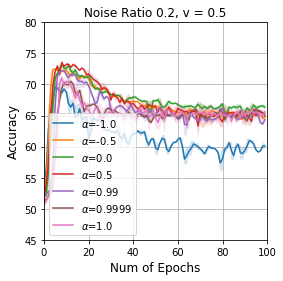

In [76]:
selection_dict = {"noise_ratio": 0.2, 
                  "v":0.5,
                  "weight_decay": 0,
                  "model": "LSTMATT",
                  "dataset": "IMDB"}
iter_var='alpha'
iter_var_name=r'$\alpha$'

plt.figure(figsize=(4,4))
plot_label_noise(selection_dict, iter_var, iter_var_name)
plt.legend()
plt.title(r"Noise Ratio 0.2, v = 0.5", fontsize=12)
plt.xlabel("Num of Epochs", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.xlim([0, 100])
plt.ylim([45, 80])
plt.grid()
plt.show()

SELECT v, path FROM tasks WHERE noise_ratio=0.2 and alpha=0.5 and weight_decay=0 and model="LSTMATT" and dataset="IMDB" ORDER BY v ASC 
IterVar      IterValue    SubSeqLen     Best      AVE
---------  -----------  -----------  -------  -------
v                 0.25            3  72.8617  64.5415
v                 0.5             2  73.5627  65.1328
v                 1               2  71.3811  65.4366
v                 2               2  71.3608  66.7506


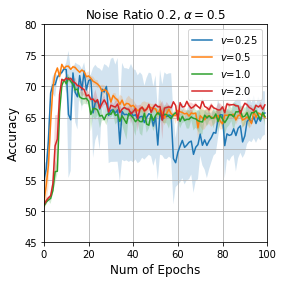

In [66]:
selection_dict = {"noise_ratio": 0.2, 
                  "alpha":0.5,
                  "weight_decay": 0,
                  "model": "LSTMATT",
                  "dataset": "IMDB"}
iter_var='v'
iter_var_name=r'$v$'

plt.figure(figsize=(4,4))
plot_label_noise(selection_dict, iter_var, iter_var_name, iter_filter=lambda x: x<4)
plt.legend()
plt.title(r"Noise Ratio 0.2, $\alpha=0.5$", fontsize=12)
plt.xlabel("Num of Epochs", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.xlim([0, 100])
plt.ylim([45, 80])
plt.grid()
plt.show()

## CIFAR 10

SELECT alpha, path FROM tasks WHERE noise_ratio=0.4 and v=0.25 and weight_decay=0 and model="ResNet18" and dataset="CIFAR10" ORDER BY alpha ASC 
IterVar      IterValue    SubSeqLen     Best      AVE
---------  -----------  -----------  -------  -------
alpha          -1                 5  78.7144  77.464
alpha          -0.5               2  80.1473  72.4955
alpha           0                 2  80.894   74.329
alpha           0.5               1  79.9496  71.9625
alpha           0.99              1  80.9484  72.2785
alpha           0.9999            1  78.8271  56.0156
alpha           1                 1  77.6701  56.1921


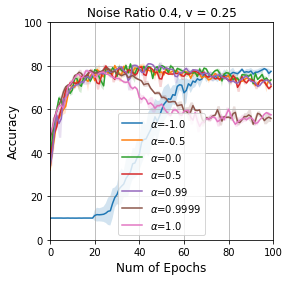

In [67]:
selection_dict = {"noise_ratio": 0.4,
                  "v":0.25,
                  "weight_decay": 0,
                  "model": "ResNet18",
                  "dataset": "CIFAR10"}

iter_var='alpha'
iter_var_name=r'$\alpha$'

plt.figure(figsize=(4,4))
plot_label_noise(selection_dict, iter_var, iter_var_name)
plt.legend()
plt.title(r"Noise Ratio 0.4, v = 0.25", fontsize=12)
plt.xlabel("Num of Epochs", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.xlim([0, 100])
plt.ylim([0, 100])
plt.grid()
plt.show()

SELECT v, path FROM tasks WHERE noise_ratio=0.4 and alpha=-1 and weight_decay=0 and model="ResNet18" and dataset="CIFAR10" ORDER BY v ASC 
IterVar      IterValue    SubSeqLen     Best      AVE
---------  -----------  -----------  -------  -------
v                 0.25            5  78.7144  77.464
v                 0.5             2  78.9062  73.9527
v                 1               2  77.6652  54.2989
v                 2               2  78.6491  55.8895


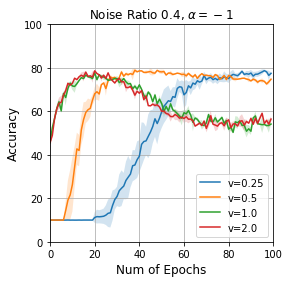

In [68]:
selection_dict = {"noise_ratio": 0.4,
                  "alpha":-1,
                  "weight_decay": 0,
                  "model": "ResNet18",
                  "dataset": "CIFAR10"}

iter_var='v'
iter_var_name=r'v'

plt.figure(figsize=(4,4))
plot_label_noise(selection_dict, iter_var, iter_var_name)
plt.legend()
plt.title(r"Noise Ratio 0.4, $\alpha=-1$", fontsize=12)
plt.xlabel("Num of Epochs", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.xlim([0, 100])
plt.ylim([0, 100])
plt.grid()
plt.show()

SELECT alpha, path FROM tasks WHERE noise_ratio=0.8 and v=0.25 and weight_decay=0 and model="ResNet18" and dataset="CIFAR10" ORDER BY alpha ASC 
IterVar      IterValue    SubSeqLen     Best      AVE
---------  -----------  -----------  -------  -------
alpha          -1                 4  25.1879  24.2415
alpha          -0.5               3  43.6907  41.0071
alpha           0                 3  44.5675  40.3745
alpha           0.5               4  44.645   39.4843
alpha           0.99              2  44.8378  35.5291
alpha           0.9999            2  42.2122  16.782
alpha           1                 2  38.7164  16.7029


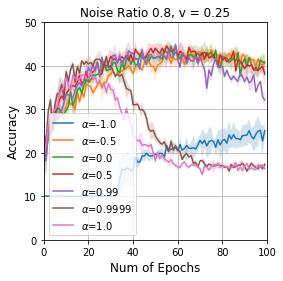

In [69]:
selection_dict = {"noise_ratio": 0.8,
                  "v":0.25,
                  "weight_decay": 0,
                  "model": "ResNet18",
                  "dataset": "CIFAR10"}

iter_var='alpha'
iter_var_name=r'$\alpha$'

plt.figure(figsize=(4,4))
plot_label_noise(selection_dict, iter_var, iter_var_name)
plt.legend()
plt.title(r"Noise Ratio 0.8, v = 0.25", fontsize=12)
plt.xlabel("Num of Epochs", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.xlim([0, 100])
plt.ylim([0, 50])
plt.grid()
plt.show()

SELECT v, path FROM tasks WHERE noise_ratio=0.8 and alpha=0.5 and weight_decay=0 and model="ResNet18" and dataset="CIFAR10" ORDER BY v ASC 
IterVar      IterValue    SubSeqLen     Best      AVE
---------  -----------  -----------  -------  -------
v                 0.15            3  40.0481  38.3703
v                 0.2             3  44.0038  42.0517
v                 0.25            4  44.645   39.4843
v                 0.5             3  42.7874  18.5845
v                 1               3  39.0625  16.9663
v                 2               2  39.7992  16.7296


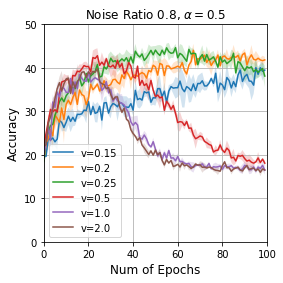

In [70]:
selection_dict = {"noise_ratio": 0.8,
                  "alpha":0.5,
                  "weight_decay": 0,
                  "model": "ResNet18",
                  "dataset": "CIFAR10"}

iter_var='v'
iter_var_name=r'v'

plt.figure(figsize=(4,4))
plot_label_noise(selection_dict, iter_var, iter_var_name)
plt.legend()
plt.title(r"Noise Ratio 0.8, $\alpha=0.5$", fontsize=12)
plt.xlabel("Num of Epochs", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.xlim([0, 100])
plt.ylim([0, 50])
plt.grid()
plt.show()

# MNIST

SELECT alpha, path FROM tasks WHERE noise_ratio=0.4 and v=0.5 and weight_decay=0 and model="DNN" and dataset="MNIST" ORDER BY alpha ASC 
IterVar      IterValue    SubSeqLen     Best      AVE
---------  -----------  -----------  -------  -------
alpha          -1                 1  89.3888  89.2054
alpha          -0.5               1  89.1367  89.0477
alpha           0                 1  89.2356  89.1208
alpha           0.5               1  89.2257  89.0289
alpha           0.99              1  90.0069  89.8363
alpha           0.9999            1  96.0344  95.9365
alpha           1                 1  96.0344  94.8042


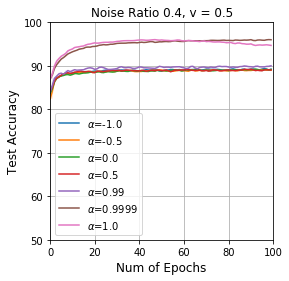

In [81]:
selection_dict = {"noise_ratio": 0.4,
                  "v":0.5,
                  "weight_decay": 0,
                  "model": "DNN",
                  "dataset": "MNIST"}

iter_var='alpha'
iter_var_name=r'$\alpha$'

plt.figure(figsize=(4,4))
plot_label_noise(selection_dict, iter_var, iter_var_name)
plt.legend()
plt.title(r"Noise Ratio 0.4, v = 0.5", fontsize=12)
plt.xlabel("Num of Epochs", fontsize=12)
plt.ylabel("Test Accuracy", fontsize=12)
plt.xlim([0, 100])
plt.ylim([50, 100])
plt.grid()
plt.show()

SELECT v, path FROM tasks WHERE noise_ratio=0.4 and alpha=0.99 and weight_decay=0 and model="DNN" and dataset="MNIST" ORDER BY v ASC 
IterVar      IterValue    SubSeqLen     Best      AVE
---------  -----------  -----------  -------  -------
v                 0.25            1  84.6025  83.792
v                 0.5             1  90.0069  89.8363
v                 1               1  95.0801  94.9446
v                 2               1  96.0591  95.9588
v                 4               1  95.9553  95.1325


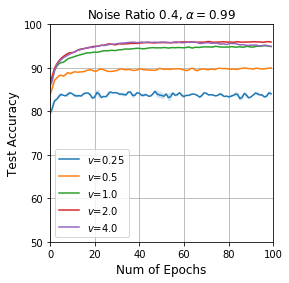

In [78]:
selection_dict = {"noise_ratio": 0.4,
                  "alpha":0.99,
                  "weight_decay": 0,
                  "model": "DNN",
                  "dataset": "MNIST"}

iter_var='v'
iter_var_name=r'$v$'

plt.figure(figsize=(4,4))
plot_label_noise(selection_dict, iter_var, iter_var_name)
plt.legend()
plt.title(r"Noise Ratio 0.4, $\alpha=0.99$", fontsize=12)
plt.xlabel("Num of Epochs", fontsize=12)
plt.ylabel("Test Accuracy", fontsize=12)
plt.xlim([0, 100])
plt.ylim([50, 100])
plt.grid()
plt.show()

SELECT alpha, path FROM tasks WHERE noise_ratio=0.8 and v=0.5 and weight_decay=0 and model="DNN" and dataset="MNIST" ORDER BY alpha ASC 
IterVar      IterValue    SubSeqLen     Best      AVE
---------  -----------  -----------  -------  -------
alpha          -1                 1  86.0314  85.712
alpha          -0.5               1  85.5024  85.1454
alpha           0                 1  86.5358  86.0819
alpha           0.5               1  87.1786  86.5759
alpha           0.99              1  86.6297  86.07
alpha           0.9999            1  86.8127  77.5766
alpha           1                 1  86.5358  52.858


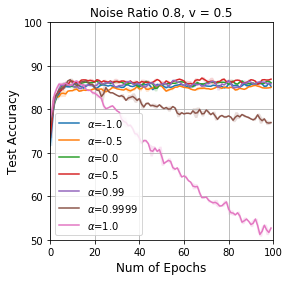

In [79]:
selection_dict = {"noise_ratio": 0.8,
                  "v":0.5,
                  "weight_decay": 0,
                  "model": "DNN",
                  "dataset": "MNIST"}

iter_var='alpha'
iter_var_name=r'$\alpha$'

plt.figure(figsize=(4,4))
plot_label_noise(selection_dict, iter_var, iter_var_name)
plt.legend()
plt.title(r"Noise Ratio 0.8, v = 0.5", fontsize=12)
plt.xlabel("Num of Epochs", fontsize=12)
plt.ylabel("Test Accuracy", fontsize=12)
plt.xlim([0, 100])
plt.ylim([50, 100])
plt.grid()
plt.show()

SELECT v, path FROM tasks WHERE noise_ratio=0.8 and alpha=0.99 and weight_decay=0 and model="DNN" and dataset="MNIST" ORDER BY v ASC 
IterVar      IterValue    SubSeqLen     Best      AVE
---------  -----------  -----------  -------  -------
v                 0.25            1  83.2723  82.1371
v                 0.5             1  86.6297  86.07
v                 1               1  87.7571  81.9289
v                 2               1  87.3121  67.2592
v                 4               1  85.5024  53.6803


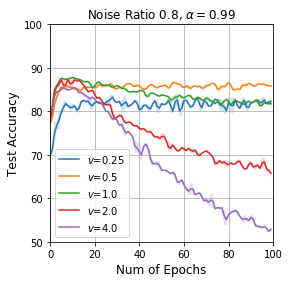

In [80]:
selection_dict = {"noise_ratio": 0.8,
                  "alpha":0.99,
                  "weight_decay": 0,
                  "model": "DNN",
                  "dataset": "MNIST"}

iter_var='v'
iter_var_name=r'$v$'

plt.figure(figsize=(4,4))
plot_label_noise(selection_dict, iter_var, iter_var_name)
plt.legend()
plt.title(r"Noise Ratio 0.8, $\alpha=0.99$", fontsize=12)
plt.xlabel("Num of Epochs", fontsize=12)
plt.ylabel("Test Accuracy", fontsize=12)
plt.xlim([0, 100])
plt.ylim([50, 100])
plt.grid()
plt.show()